In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from glob import glob
import os
import yaml
from skimage.io import imread
import stretchablecorr as sc

# Stretchable Corr - Post-process

## Search and select images

In [3]:
def get_stretch(image_name, sample_name):
    """extract stretch value from filename

    ex: hpr10p100031.TIF --> 0.1%
    """
    image_name = image_name.replace(sample_name, '')
    image_name = image_name.split('.')[0]
    u, d = image_name.split('p')
    d = d[:1]
    s = float(u) + float(d)/10
    return s

Available samples
0 - example_PDMS_18j
1 - .ipynb_checkpoints
2 - not_used
3 - HS2
4 - hpr1


> Select an image directory: 3


HS2 selected
Load images from ./images/HS2...
Image sequence:
 23 frames , 1392*1024 pixels , memory size: 250 Mo
 images: 00p000001.TIF, 00p100012.TIF, 00p200023.TIF , ... ,  55p000267.TIF


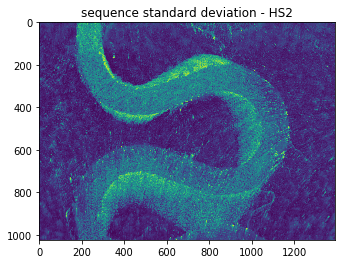

In [5]:
# ==================
#  Load image cube
# ==================
sample_name, sample_input_dir = sc.select_sample_dir('./images')
cube, image_names = sc.load_image_sequence(sample_input_dir)

output_dir = 'output'
resultdir = os.path.join(output_dir, sample_name)

# Graph std
plt.figure(); plt.title(f'sequence standard deviation - {sample_name}');
plt.imshow(np.std(cube, axis=0), cmap='viridis');
sc.save_fig('01_cube_std', sample_name, output_dir=output_dir)

# Extract stretch value from filenames
#stretch_values = [get_stretch(n, 'hpr1') for n in image_names]
#print('\n', f'{len(stretch_values)} stretch values extracted')

## Lagrangian displacement

In [7]:
# ========================
#  List available dataset
# ========================
datasets = glob(os.path.join(resultdir, '*.pck'))

print(f'Available dataset for {sample_name}')
print( '======================' + '='*len(sample_name) )
sc.print_numbered_list([os.path.basename(d) for d in datasets])

# Select a sample:
dataset_id = input('> Select a file:')
data_file = datasets[int(dataset_id)]
print(data_file)

# Load dataset
with open(data_file, 'rb') as f:
    grid, displ, err, meta = pickle.load(f)

window_half_size = meta['window_half_size']
points = np.stack( (grid[0].flatten(), grid[1].flatten()), axis=-1 )

print('')
print('Parameters:')
print('===========')
print(yaml.dump(meta, default_flow_style=False))

Available dataset for HS2
0 - displ_Lagrangian_1120pts_130127.pck
1 - displ_Lagrangian_4400pts_160905.pck
2 - displ_Lagrangian_140pts_164357.pck
3 - displ_Lagrangian_2035pts_162211.pck
4 - displ_Lagrangian_532pts_155551.pck


> Select a file: 1


output/HS2/displ_Lagrangian_4400pts_160905.pck

Parameters:
coarse_downscale: 3
coarse_param:
  method: opti
  phase: true
  window_half_size: 35
grid_margin: 100
grid_spacing: 15
method: opti
phase: false
sample_name: HS2
window_half_size: 20



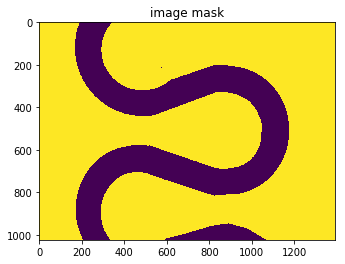

In [8]:
# =========================
#  Load an image as a MASK
# =========================
image_mask_path = f'images/{sample_name}_mask.png'
try:
    image_mask = imread(image_mask_path)
    image_mask = ~(image_mask[:, :, -1] < 150)

    points_mask = image_mask[points[:, 1], points[:, 0]]
    points_mask = points_mask.reshape(grid[0].shape).astype(np.int)

    plt.title('image mask')
    plt.imshow(image_mask)

    #points_mask = np.logical_not( points_mask )
    #print(points_mask[0, 0])
except:
    print(f'no image mask found ({image_mask_path})')
    points_mask = None

## Graph error

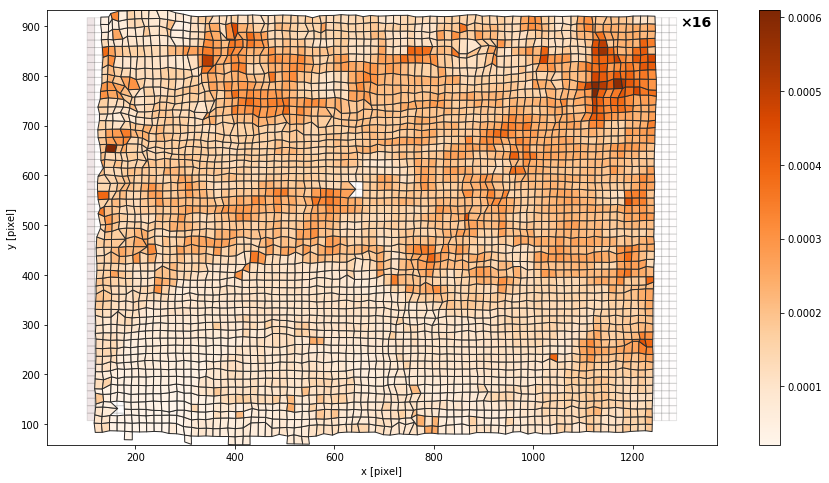

In [41]:
err_H = err[:, :, 1].reshape([err.shape[0], *grid[0].shape])

displ_to_ref = sc.integrate_displacement(displ)

k = 5
plt.figure(figsize=(15, 8));
sc.plot_deformed_mesh(grid, displ_to_ref[k],
                      color_values=err_H[k], cmap='Oranges',
                      view_factor=16)
plt.colorbar();

### Deformed mesh for all steps

In [42]:
k = 1

k= 3
(4400, 2)


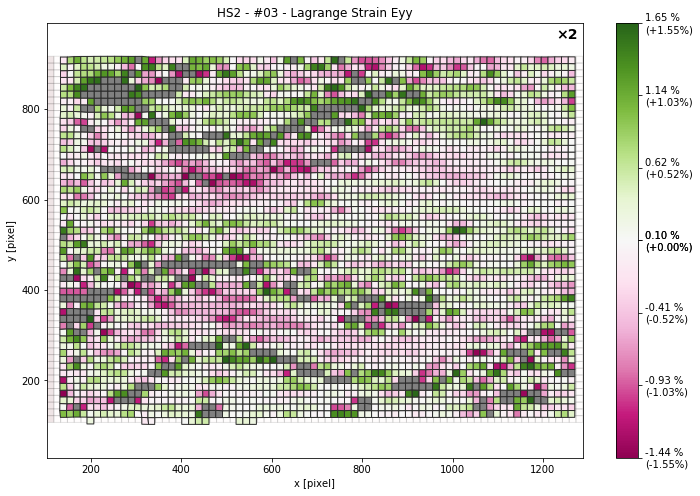

In [46]:
print('k=', k)
displ_field = displ_to_ref[k]
print(displ_field.shape)

u = displ_field[:, 0].reshape(grid[0].shape)
v = displ_field[:, 1].reshape(grid[0].shape)


view_factor = 2

# Def field shown:
E = sc.get_LagrangeStrainTensor(*grid, u, v) *100 # percent
field_value = E[:, :, 1, 1]
field_name = "Lagrange Strain Eyy"

# Graph
plt.figure(figsize=(12, 8));
sc.plot_deformed_mesh(grid, displ_field,
                      color_values=field_value,
                      view_factor=view_factor,
                      cmap='PiYG')

# Set color scale
nbr_std = 1
std = np.nanstd(field_value)

ref_value = np.nanmedian(field_value)
alpha = 0.05  # def quantile for min-max colors
half_range = max(ref_value-np.nanquantile(field_value, alpha),
                 np.nanquantile(field_value, 1-alpha)-ref_value)
c_ticks = np.linspace(-half_range + ref_value, +half_range + ref_value, 7)
c_ticks = np.sort(np.hstack([c_ticks, [ref_value, ]]))
plt.clim([np.min(c_ticks), np.max(c_ticks)])

cbar = plt.colorbar(ticks=c_ticks);
cbar.ax.set_yticklabels([f'{u:.2f} %\n({u-ref_value:+0.2f}%)' for u in c_ticks]) ;
#cbar.ax.get_yticklabels()[1].set_color('red') 

plt.title(f'{sample_name} - #{k:02d} - {field_name}')

k += 1

In [44]:
### old

In [ ]:
view_factor = 3
Poisson_coeff = 0.3
eps_zz_limits = -10, 10 # None  #
save = False

for image_id, displ_field in enumerate(displ_to_ref):

    eps_xx, eps_yy, eps_zz = finite_diff_strain(grid, displ_field, nu=Poisson_coeff)
    field_value = eps_yy
    field_value_name = 'eps_z'
    
    if points_mask is not None:
        field_value[points_mask] = np.NaN
    
    plt.figure(figsize=(15, 8));
    sc.plot_deformed_mesh(grid, displ_field,
                          color_values=field_value,
                          view_factor=view_factor,
                          cmap='jet') #Spectral

    if eps_zz_limits:
        plt.clim(*eps_zz_limits)
    else:
        clim = np.nanmax(np.abs(field_value))
        plt.clim([-clim, +clim])
        
    title =  f'{sample_name} - {stretch_values[image_id]}% - '
    title += f'{image_names[image_id]} - '
    #title += f'eps_zz [%] (nu={Poisson_coeff}) - '
    title += f'{field_value_name} [%] - '
    title += f'displ. scale x{view_factor}'
    plt.title(title);
    
    if save:
        output_dir = f'{field_value_name}_maps' if points_mask is None else f'{field_value_name}_maps_mask'
        sc.save_fig(f'{field_value_name}_{image_id:03d}',
                    sample_name,
                    output_dir, close=True)
    
print('\n done')